# Stock Market Simulation

In [440]:
import os, re 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from datetime import datetime as dt 

import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import numpy as np 
import pandas as pd 
import seaborn as sns 

import plotly.io as pio
pio.renderers.default = 'iframe'

# Load Stock Market Data for Intel

In [441]:
c = pyEX.Client(api_token='pk_ec1c02597eb748d59f41d09900f0de17')
NUM_DAYS = 10000     
INTERVAL = '1d'     
symbol = 'intc' 

In [442]:
df = yf.download(symbol)
df.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
df = df.loc[df.index > '2000-01-01']
print(df.head())

[*********************100%***********************]  1 of 1 completed
                 open     high       low     close  Adj Close    volume
Date                                                                   
2000-01-03  41.632812  43.6875  41.62500  43.50000  26.234381  57710200
2000-01-04  42.718750  43.9375  41.12500  41.46875  25.009356  51019600
2000-01-05  41.500000  42.9375  40.25000  41.81250  25.216669  52389000
2000-01-06  40.875000  41.6875  39.09375  39.37500  23.746641  55171200
2000-01-07  38.750000  41.0000  38.68750  41.00000  24.726658  41096400


In [443]:
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
fig = go.Figure(data=[go.Candlestick(x=df.index, open=df['open'], high=df['high'], low=df['low'], close=df['close'])])
fig.show()

**Shift our target back a day**

In [444]:
df['close'] = df['close'].shift(1)
cols = ['open','close','volume']
train = df[cols][5:]

/var/folders/md/c9lgr11n7x1c0_tghtfh_kjr0000gn/T/ipykernel_16230/2276575286.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [445]:
prior_date = '2022-01-01'
X_train = train.loc[train.index<=prior_date].drop(columns=['close'])
X_val = train.loc[train.index>prior_date].drop(columns=['close'])
y_train = train.loc[train.index<=prior_date]['close']
y_val = train.loc[train.index>prior_date]['close']

0.9899601870139444


<AxesSubplot:ylabel='close'>

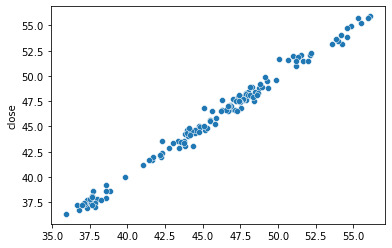

In [556]:
model = LinearRegression()
model.fit(X_train,y_train)
preds = model.predict(X_val)
print(r2_score(y_val, preds))
sns.scatterplot(x=preds, y=y_val)

<AxesSubplot:xlabel='Date'>

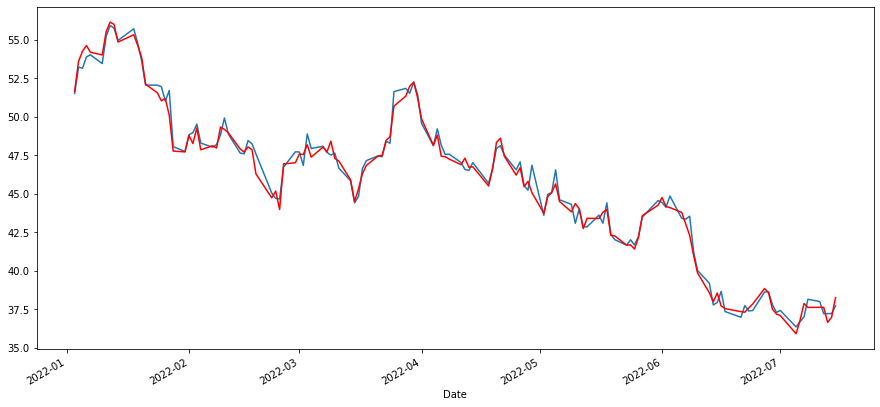

In [557]:
validation = pd.DataFrame(y_val).reset_index()
validation['pred'] = preds
validation.set_index('Date',inplace=True)
validation['close'].plot(kind='line', figsize=(15,7))
validation['pred'].plot(kind='line', color='red')

# Monte Carlo Simulation

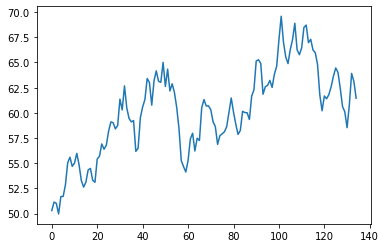

In [563]:
m = train.loc[train.index<='2022-01-01']
returns = m['close'].pct_change()
daily_vol = returns.std()
daily_vol

d = 134 # 134 days prediction 
count = 0
price_list = []
last_price = m['close'][-1]

price = last_price * (1 + np.random.normal(0, daily_vol))
price_list.append(price)

for y in range(d):
    if count == d:
        break
    price = price_list[count]* (1 + np.random.normal(0, daily_vol))
    price_list.append(price)
    count += 1

plt.plot(price_list)
plt.show()


**Notice the plot changes variably each execution.**

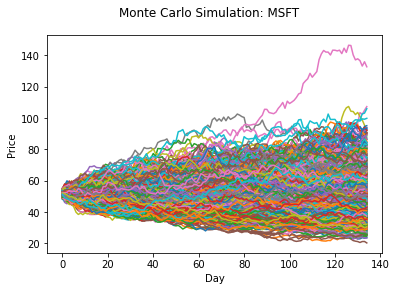

In [566]:
T=134
NUM_SIMULATIONS =  1000
p = pd.DataFrame()
last_price_list = []
for x in range(NUM_SIMULATIONS):
    count = 0
    price_list = []
    price = last_price * (1 + np.random.normal(0, daily_vol))
    price_list.append(price)
    
    for y in range(T):
        if count == 251:
            break
        price = price_list[count]* (1 + np.random.normal(0, daily_vol))
        price_list.append(price)
        count += 1
    p = pd.concat([p, pd.Series(price_list, name=x)], axis=1)    
    last_price_list.append(price_list[-1])
        
fig = plt.figure()
fig.suptitle("Monte Carlo Simulation: MSFT")
plt.plot(p)
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

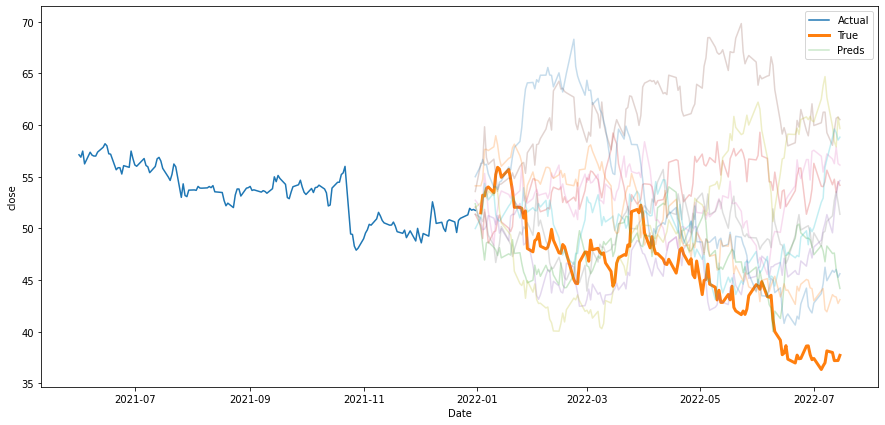

In [581]:
sliced = df.loc[((df.index <= '2022-01-01') & (df.index >= '2021-06-01'))]
dates = df.loc[df.index >= '2021-12-31'].index
p['date'] = dates
p.set_index('date',inplace=True)

fig,axs = plt.subplots(1, figsize=(15,7))
sns.lineplot(x=sliced.index, y=sliced['close'], ax=axs)
sns.lineplot(x=y_val.index, y=y_val, ax=axs, linewidth=3,)

for col in p.columns[:10]: 
    sns.lineplot(x=p.index, y=p[col], ax=axs, alpha=.25)
plt.legend(labels=['Actual','True', 'Preds'])